# Introduction

As a recent immigrant, I am faced with the challenge of establishing a stable income while juggling responsibilities. To supplement my livelihood, I have taken up work as a delivery shopper during my available hours. Drawing from my professional background as a data scientist/analyst, I aim to leverage data analysis to optimize my earnings in this role.
<br>
Each shopping opportunity presented through the app demands quick decision-making based on various factors such as the order's pay, travel distance, number of items, store name, and batch size, among others. These decisions must be made promptly, as competing shoppers are ready to take on orders swiftly. To make informed choices efficiently, I have developed this notebook to devise a formula that aids in rapid decision-making.
<br>
The primary focus of this notebook is to predict the 'Active Time' for each order, serving as the target variable. By combining this prediction with my desired pay rate, I can make well-informed decisions on which orders to accept, optimizing my earnings within the limited timeframe available.

# Objectives

Objectives of this project is to answer:

1.   Is there exist a simple formula to make decision whether to take order?
2.   What pay should have for given order information and my desire pay rate?
3.   Which location is more profitable?
4.   Which time period is more profitable?
5.   Which weekday is more profitable?

# Define Constants

In [239]:
desire_rate = 18 # Desire pay rate per hour
oil_cost = .1 # average oil cost per km

#Library

In [240]:
# Link to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [241]:
# Core
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)

# Statsmodel
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Data

## Load Data

In [242]:
# Read data
data=pd.read_csv('/content/gdrive/My Drive/Python/dataset/Instacart_data.csv', parse_dates = ['Date'])

## Change data type

In [243]:
# Parse time data
data['Time'] = pd.to_datetime(data['Time'], format='%H%M').dt.strftime('%H:%M:%S')
# Change "On my way" to boolean
data['On_my_way'] = data['On_my_way'].astype(bool)

In [244]:
print("data shape:", data.shape)
data.head()

data shape: (56, 12)


,Date,Time,Pay,Batch,Location,Store,Item,Unit,Start_km,Display_km,Active_time,On_my_way
0,2024-03-04,11:41:00,38.36,3,Shawnessy,Walmart,39,54,0.3,11.0,83,False
1,2024-03-04,13:28:00,39.34,3,Shawnessy,Walmart,44,52,0.1,15.5,94,False
2,2024-03-03,16:43:00,43.01,2,Shawnessy,Walmart,53,70,0.3,10.0,143,False
3,2024-02-27,09:46:00,24.52,1,Shawnessy,Walmart,19,20,0.3,4.3,72,False
4,2024-02-27,13:44:00,15.99,1,Shawnessy,Michaels,10,11,0.3,2.4,46,False


## Data Descriptions

*   **Date**: Date of the Order Received
*   **Time**: Time of the Order Received
*   **Pay**: Payment for the Order
*   **Batch**: Number of Batches in the Order
*   **Location**: Location of the Store to Shop
*   **Store**: Name of the Store
*   **Item**: Number of Items in the Order
*   **Unit**: Total Units of Goods in the Order
*   **Start km**: Distance to the Store at Order Acceptance
*   **Display km**: Estimated Distance to be Traveled
*   **Active time**: Time Taken to Complete the Order
*   **On_my_way**: Is it a trip to my destination?

## Data Statistics

In [245]:
data.describe()

,Pay,Batch,Item,Unit,Start_km,Display_km,Active_time
count,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000,56.000000
mean,26.719107,1.964286,27.035714,36.071429,1.969643,8.775000,86.964286
std,12.069670,0.852041,16.090612,22.685083,3.317169,5.773269,36.543854
min,8.690000,1.000000,2.000000,2.000000,0.000000,1.300000,20.000000
25%,17.055000,1.000000,13.000000,19.500000,0.300000,5.100000,63.500000
50%,25.510000,2.000000,23.000000,33.000000,0.300000,7.400000,83.000000
75%,33.952500,3.000000,39.500000,52.500000,1.925000,11.800000,109.250000
max,61.780000,3.000000,58.000000,101.000000,16.900000,29.100000,167.000000


## Missing Value

In [246]:
print("Dataset Missing Values:")
print(data.isna().sum())

Dataset Missing Values:
Date           0
Time           0
Pay            0
Batch          0
Location       0
Store          0
Item           0
Unit           0
Start_km       0
Display_km     0
Active_time    0
On_my_way      0
dtype: int64


## Duplicate Value

In [247]:
print(f"Dataset Duplicates: {data.duplicated().sum()}, ({np.round(100*data.duplicated().sum()/len(data),1)})")

Dataset Duplicates: 0, (0.0)


##Data Type of Features

There are 6 continuous features (Pay, Unit, Item, Start_km, Display_km, Active_time), 3 categorical features (Batch, Location, Store) and 3 descriptive features (Date, Time, On_my_way).

In [248]:
data.dtypes

Date           datetime64[ns]
Time                   object
Pay                   float64
Batch                   int64
Location               object
Store                  object
Item                    int64
Unit                    int64
Start_km              float64
Display_km            float64
Active_time             int64
On_my_way                bool
dtype: object

## Categroical Data Skewness

In [249]:
data['Batch'].value_counts()

1    21
3    19
2    16
Name: Batch, dtype: int64

In [250]:
data['Location'].value_counts()

Shawnessy    34
Macleod      12
Heritage      6
NE            4
Name: Location, dtype: int64

In [251]:
data['Store'].value_counts()

Walmart        41
Superstore      8
Costco          3
Giant Tiger     2
Michaels        1
Sephora         1
Name: Store, dtype: int64

There are too few record of Giant Tiger, Michaels and Sephora, which will cause problem when prediction take place. This issue will be address in Feature Engineering Section.

# Exploratory Data Analysis

## Target Distribution

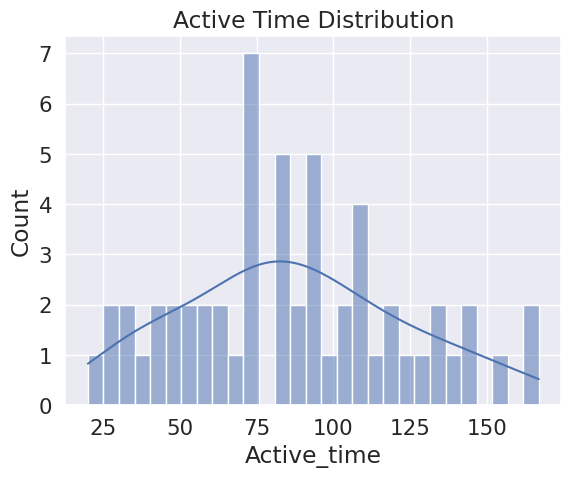

In [252]:
sns.histplot(data=data,
             x='Active_time',
             kde=True,
             binwidth=5)

plt.title('Active Time Distribution')
plt.show()

*Insights:*
1.   Active Time Analysis:
*   Range of Active Time: The active time for individual orders spans from 25 to 160 minutes, with an average around 85 minutes (approximately 1.5 hours).
2.   Desired Pay Calculation:
*   Using the mean active time alongside my desired pay rate (e.g., $18/hr), the estimated average pay I aim for is approximately $25.5 per order.

## Continuous Features

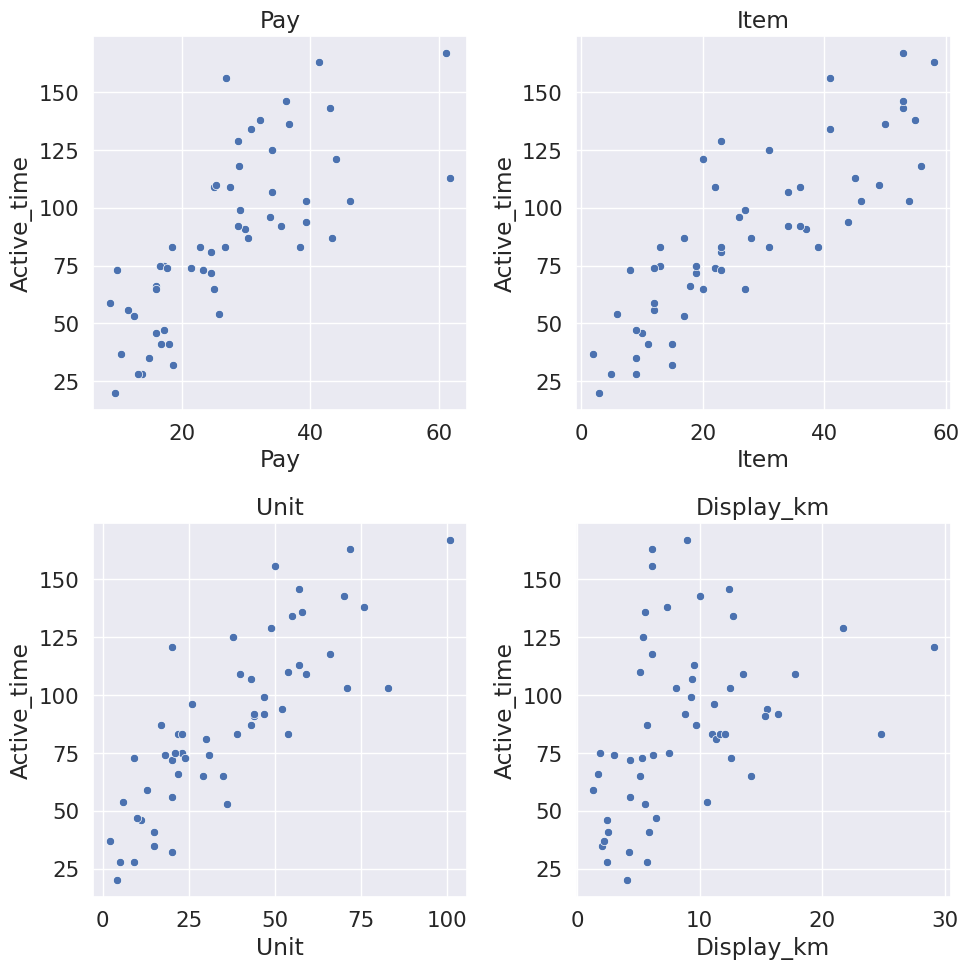

In [253]:
# Continuous features and Target
con_feats = ['Pay', 'Item', 'Unit', 'Display_km']

fig= plt.figure(figsize=(10,10))
for i, var in enumerate(con_feats):
  ax=fig.add_subplot(2,2,i+1)
  sns.scatterplot(data=data, x=var, y='Active_time', ax=ax)
  ax.set_title(var)

fig.tight_layout()
plt.show()

*Notes:*
1.   Distance Consideration:
*   As starting km is not readily available in the order information, it is not factored into the analysis at this stage.

*Insights:*
1.   Variable Relationships:
*   Continuous Variables: All continuous variables exhibit a positive relationship with Active Time.

## Categorical Features

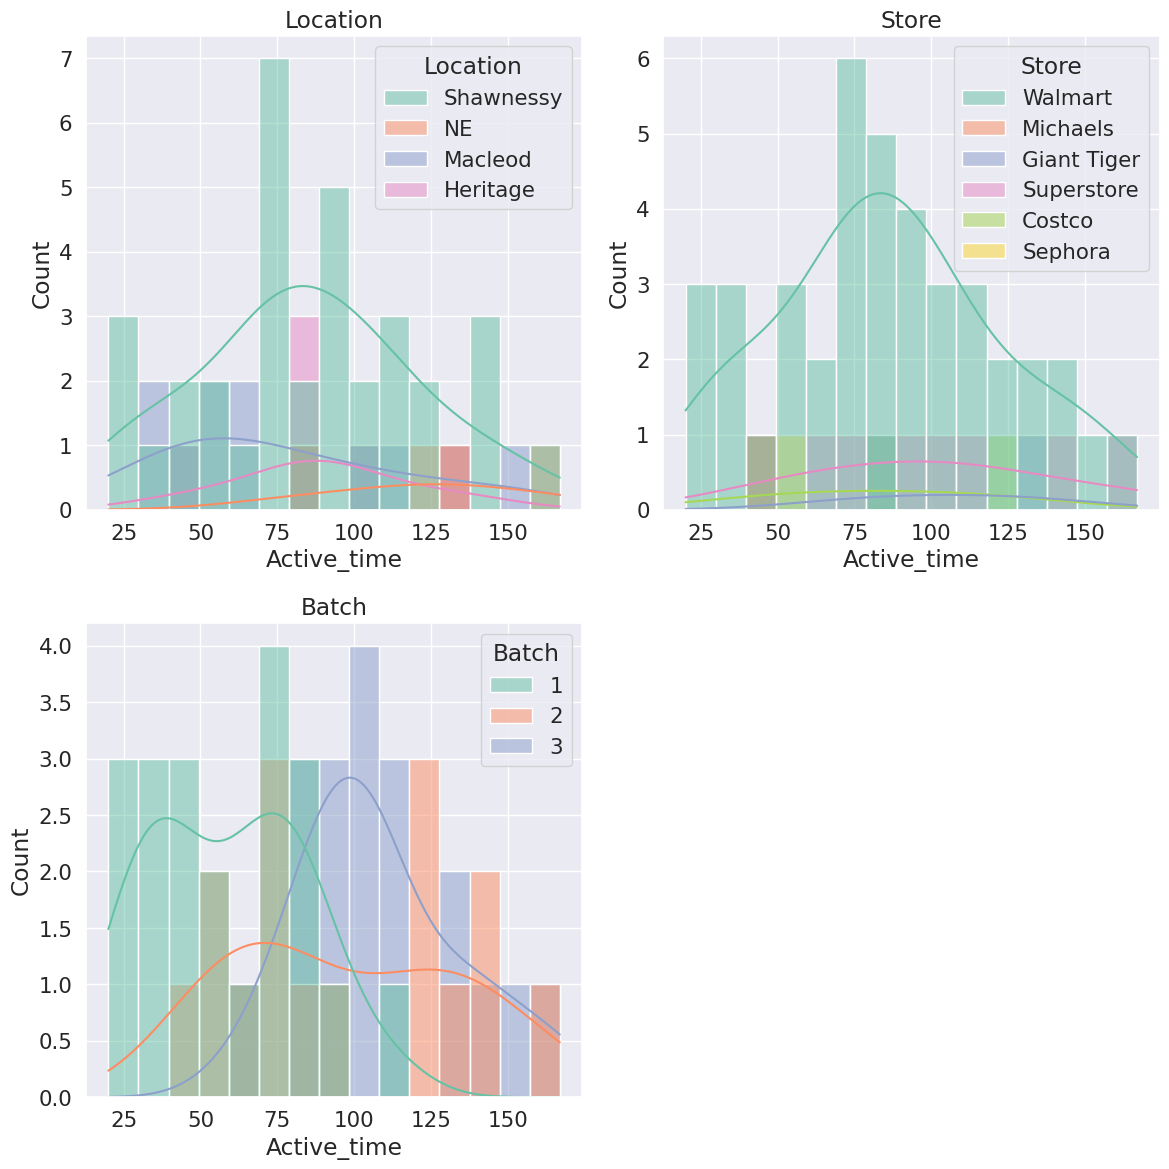

In [254]:
# Categorical features
cat_feats = ['Location', 'Store', 'Batch']

# Plot categorical features
fig = plt.figure(figsize=(12,12))
for i, var in enumerate(cat_feats):
  ax=fig.add_subplot(2,2,i+1)
  sns.histplot(data=data, x='Active_time', hue=var, kde=True, binwidth=10, palette='Set2', ax=ax)
  ax.set_title(var)

fig.tight_layout()
plt.show()

*Notes:*
1.   Location and Store Insights:
*   The dataset is skewed towards Shawnessy and Walmart, potentially limiting insights into other locations and stores.
*   Active times vary across different batch sizes, with Batch 2 showing higher variance and Batch 3 displaying lower variance.

*Insights:*
1.   Batch Size Analysis:
*   Active times differ significantly based on batch size:
Batch 1 and 2 exhibit wide spreads, with mean active times around 59 and 90 minutes, respectively.
*   Batch 3 is more concentrated, with a mean active time of 103 minutes.

2.   Profitability Estimation:
*   Calculating pay based on mean active time and desired pay rate (e.g., $18/hr) provides insights into expected earnings (e.g., mean pay of 30).

# Feature engineering

More features can be derived to find out more insights from the data

**Batch**<br>
Since batch size can only be 1, 2 or 3, it should be converted to categorical data

In [255]:
data['Batch'] = data['Batch'].astype('category')

**Store**<br>
Since there are too few record of Giant Tiger, Michaels and Sephora, they will be combined to "others"

In [256]:
data['Store'] = data['Store'].replace(['Giant Tiger', 'Michaels', 'Sephora'], "Others")

**Weekday**<br>From my experience, number of order and pay are affected by the weekday, like weekend will have more orders and tips

In [257]:
# extract weekday from date
data['Weekday'] = data.Date.dt.dayofweek + 1 # 1 = Monday, 7 = Sunday
data['Weekday'] = data['Weekday'].astype('category')

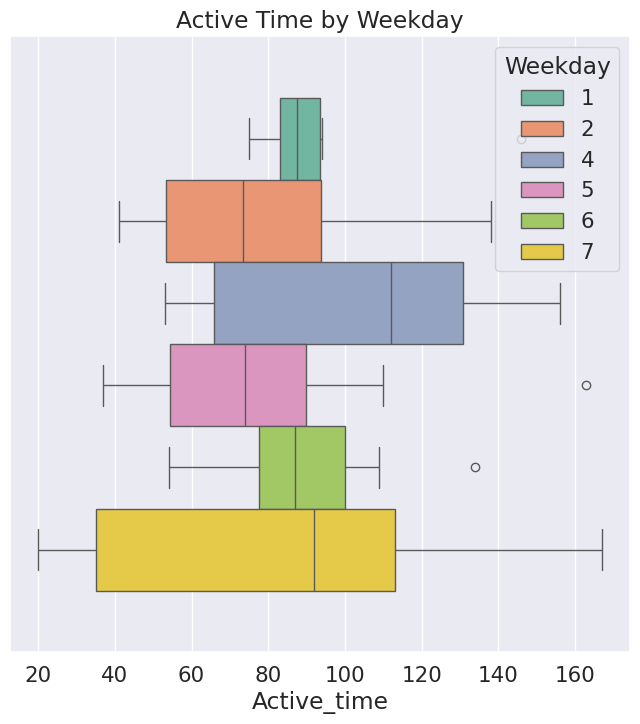

In [258]:
# box plot for weekday
fig = plt.figure(figsize=(8,8))
sns.boxplot(data=data, x='Active_time', hue='Weekday', palette='Set2')

plt.title('Active Time by Weekday')
plt.show()

**Time Period**<br>
From my experience, the time period of the day also affects order and pay. Therefore, time are splitted to periods with the following definitions:<br>
Morning: 0700-1059<br>
Lunch: 1100-1359<br>
Afternoon: 1400-1759<br>
Dinner: 1800-2059<br>
Night: 2100-2359<br>

In [259]:
# extract hour from time and convert to time period
data['Hour'] = data['Time'].str[:2].astype(int)
bins = [7, 11, 14, 18, 21, 24]
labels = ['Morning', 'Lunch', 'Afternoon', 'Dinner', 'Night']
data['Time_period'] = pd.cut(data['Hour'], bins=bins, labels=labels, right=False)
data.drop(columns=['Hour'], inplace=True)

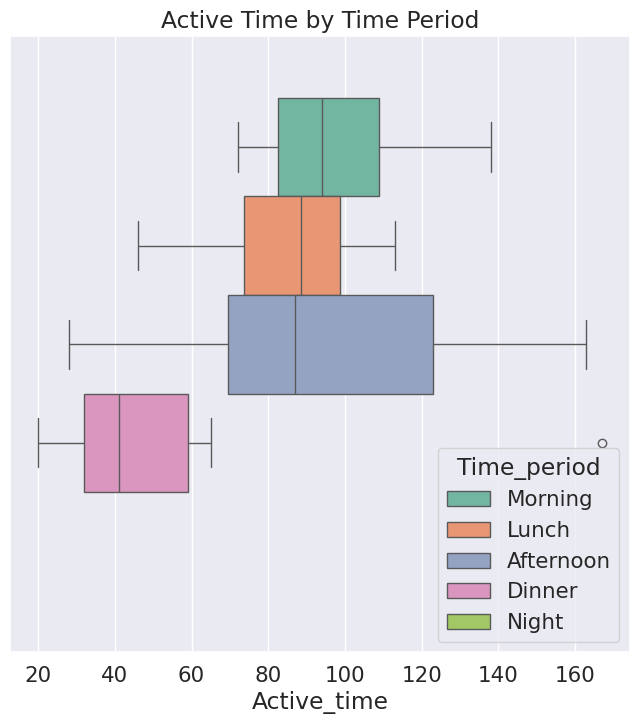

In [260]:
# Box plot of time period
fig = plt.figure(figsize=(8,8))
sns.boxplot(data=data, x='Active_time', hue='Time_period', palette='Set2')

plt.title('Active Time by Time Period')
plt.show()

**Hour**<br>
The hour when recieved order is helpful to identify rush hour which is useful to decide when to start working

In [261]:
# extract hour from time
data['Hour'] = pd.to_datetime(data['Time']).dt.hour

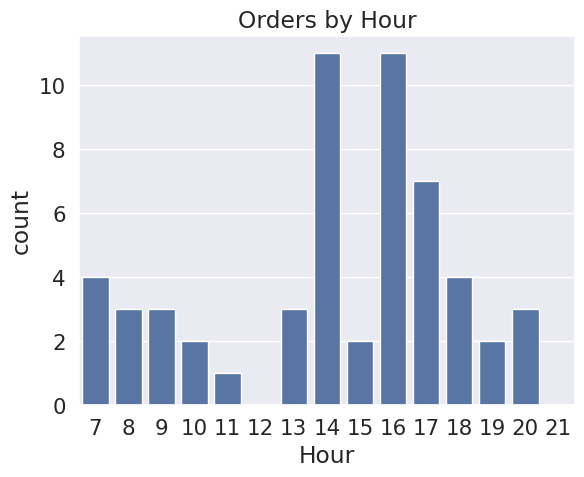

In [262]:
# Order by Hour
all_hours = list(range(7,22))
sns.countplot(data=data, x='Hour', order=all_hours)

plt.title('Orders by Hour')
plt.show()

**Total km**<br>
Calculate the total distance travelled in km

In [263]:
data['Total_km'] = data['Start_km'] + data['Display_km']

**Desire Pay**<br>
Based on my desire pay rate and oil cost, calculate the desire pay of each order

In [264]:
data['Desire_pay'] = desire_rate * data['Active_time'] / 60 + data['Total_km'] * oil_cost

**Profit_loss**<br>
Based on my desire pay and actual pay, calculate the Profit_loss

In [265]:
data['Profit_loss'] = data['Pay'] - data['Desire_pay']

**Profitable**<br>
Indicate the order has profit or not

In [266]:
data['Profitable'] = data['Profit_loss'].apply(lambda x: True if x > 0 else False)

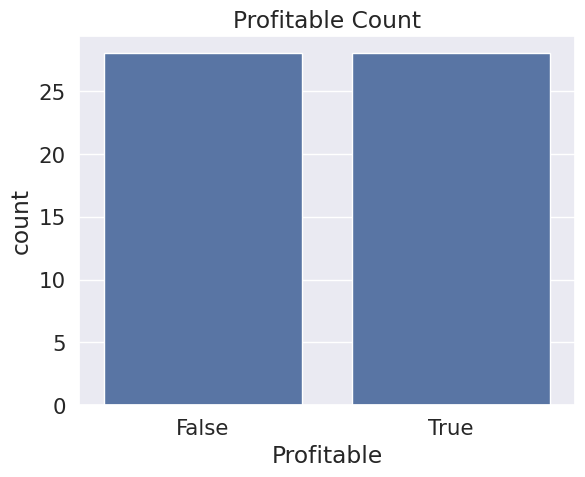

In [267]:
# Count plot
sns.countplot(data=data, x='Profitable')

plt.title("Profitable Count")
plt.show()

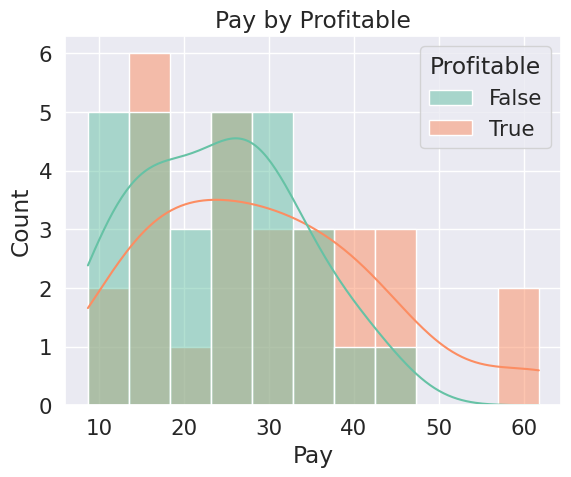

In [268]:
# Pay vs Profitable
sns.histplot(data=data, x='Pay', hue='Profitable', binwidth=5, kde=True, palette='Set2')

plt.title('Pay by Profitable')
plt.show()

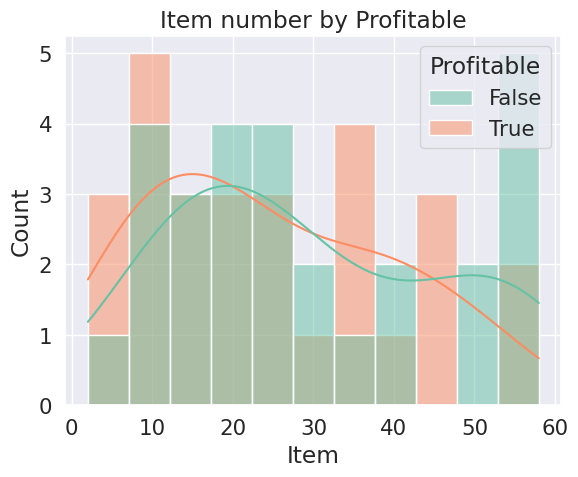

In [269]:
# Item number vs Profitable
sns.histplot(data=data, x='Item', hue='Profitable', binwidth=5, kde=True, palette='Set2')

plt.title('Item number by Profitable')
plt.show()

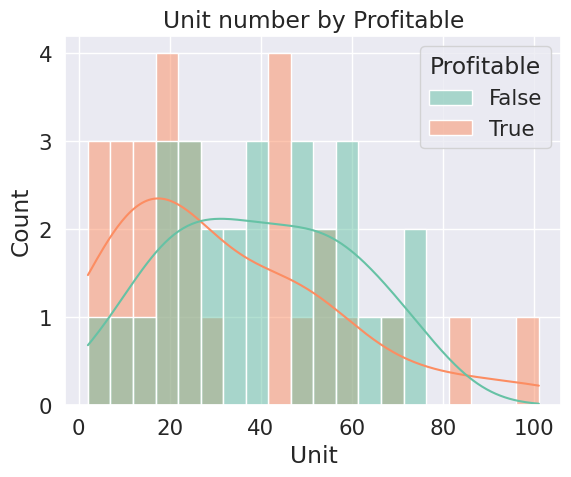

In [270]:
# Unit number vs Profitable
sns.histplot(data=data, x='Unit', hue='Profitable', binwidth=5, kde=True, palette='Set2')

plt.title('Unit number by Profitable')
plt.show()

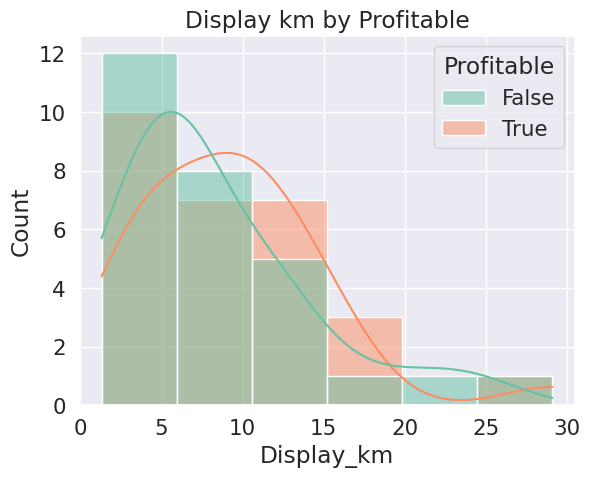

In [271]:
# Display km vs Profitable
sns.histplot(data=data, x='Display_km', hue='Profitable', binwidth=5, kde=True, palette='Set2')

plt.title('Display km by Profitable')
plt.show()

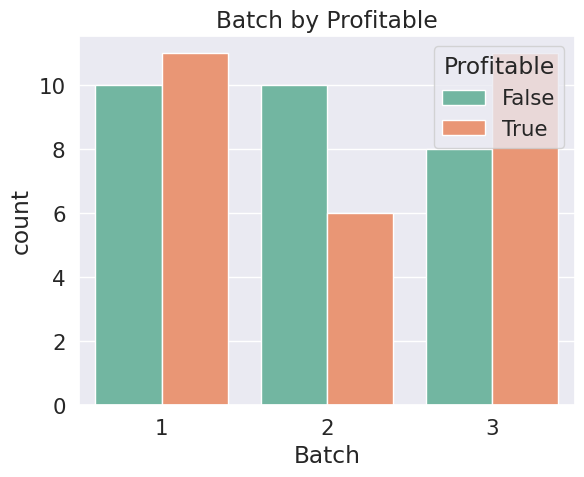

In [272]:
# Batch size and Profitable
# fig = plt.figure(figsize=(6, 8))
sns.countplot(data=data, x='Batch', hue='Profitable', palette='Set2')

plt.title('Batch by Profitable')
plt.show()

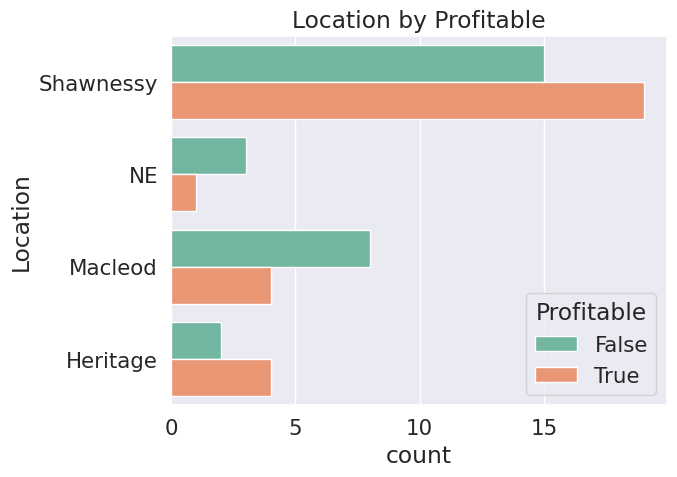

In [273]:
# Location vs Profitable
sns.countplot(data=data, y='Location', hue='Profitable', palette='Set2')

plt.title('Location by Profitable')
plt.show()

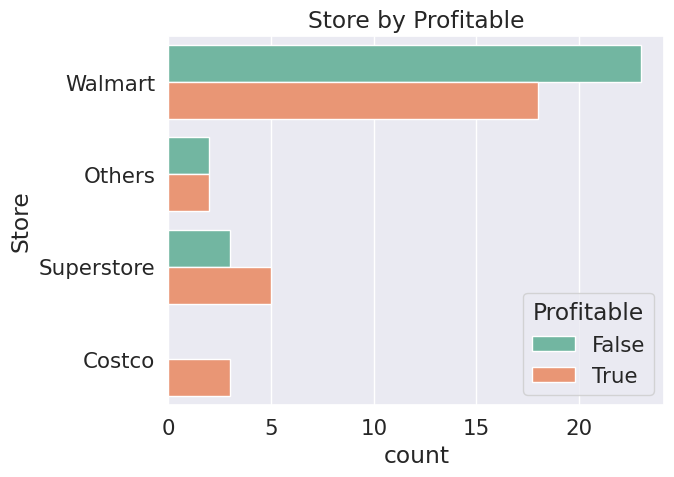

In [274]:
# Store vs Profitable
sns.countplot(data=data, y='Store', hue='Profitable', palette='Set2')

plt.title('Store by Profitable')
plt.show()

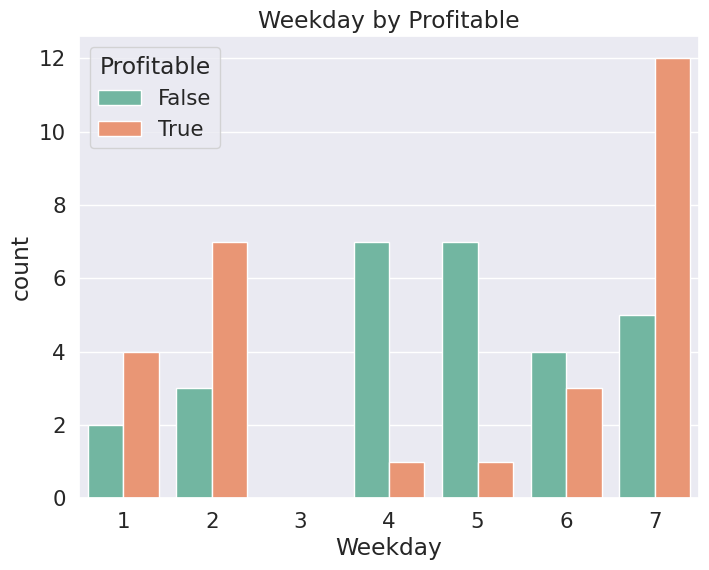

In [275]:
# Weekday vs Profitable
fig = plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='Weekday', hue='Profitable', palette='Set2', order=np.arange(1,8))

plt.title('Weekday by Profitable')
plt.show()

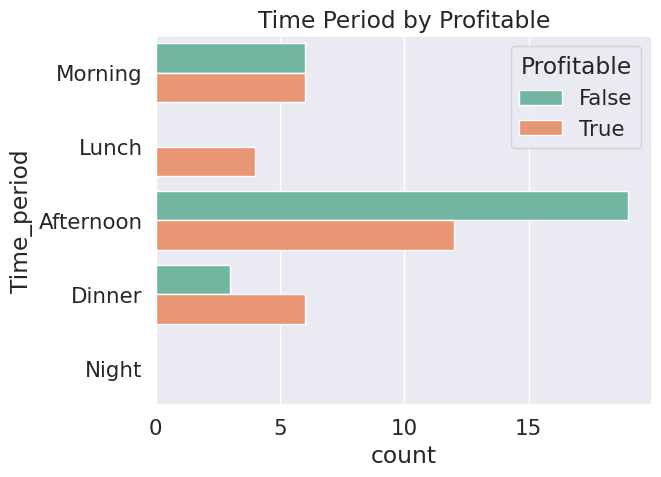

In [276]:
# Time period countplot
sns.countplot(data=data, y='Time_period', hue='Profitable', palette='Set2')

plt.title('Time Period by Profitable')
plt.show()

*Notes:*
1.   Profitability and Availability:
*   Thursdays present an opportunity for increased profitability, given more available time.
*   Availability is contingent upon a full-time job, impacting the relevance of some analysis.
2.   App Usage Insights:
*   The app sees a significant reduction in orders after 9:00 PM, with no experience working at this hour.

*Insights:*
1.   Profitable Days and Stores:
*   Sundays emerge as the most profitable days for orders.
*   Superstore orders tend to be more profitable, despite potential unpleasant experiences.
*   While Walmart records are abundant, profitability varies, possibly due to order selection.

2.   Location-Based Profitability:
*   Orders at Macleod and NE locations show lower profitability trends.

3.   Active Time Analysis:
*   Sunday sees the highest variance in active times, contrasting with Monday's stability.
*   Thursdays witness the highest median active times, indicating longer order durations.

4.   Time Period Profitability:
*   Dinner periods exhibit the shortest active times, reflecting smaller order sizes.
*   Afternoon orders generally generate less profit compared to dinner shifts.

5.   Batch Size Influence:
*   Batch size 3 orders tend to yield higher profitability, while batch size 2 orders show lesser profitability.

6.   Distance and Units:
*   Orders with greater displayed distances tend to be more profitable.
*   Orders with fewer units appear to be more profitable, suggesting potential order selection strategies.

7.   Profitability Assessment Challenges:
*   Assessing order profitability solely based on pay and item data proves challenging, with a balanced mix of profitable and non-profitable orders.less



# Preprocessing

##Split Data and Drop Unwanted Features

In [277]:
# Drop unwanted features for modeling
df = data.drop(['Date', 'Time', 'Start_km', 'On_my_way',
                'Hour', 'Total_km', 'Desire_pay',
                'Profit_loss', 'Profitable'], axis=1).copy()

In [278]:
# Train Test split
np.random.seed(169)
record = len(df)

indices = np.random.permutation(record)
split = int(.8*record)
train_idx = indices[:split]
test_idx = indices[split:]

df_train = df.iloc[train_idx]
df_test = df.iloc[test_idx]

# Modelling

## Regression Model

In [279]:
# Define a function to calculate MSE
def mse(test, pred):
  '''function to calculate the mean square error of the prediction'''
  diff = test - pred
  size = len(test)

  return sum(diff**2) / size

In [280]:
# Backward Stepwise Regression and evaluate models with different features
# Initialization
max_p = 1
indep_feat = list(df_train.columns)
indep_feat.remove('Active_time')
models = []
model_metric = {
    'rsquare': [],
    'adjrsquare': [],
    'aic': [],
    'bic': [],
    'Fvalue': [],
    'maxp': [],
    'MSE(test)': [],
    'to_be_removed': []
}

# Backward stepwise regression
while max_p > .05:
  rformula = "Active_time ~ " + "+".join(indep_feat)
  reg = smf.ols(formula=rformula, data=df_train)
  results = reg.fit()
  models.append(results)

# Record metrics
  model_metric['rsquare'].append(results.rsquared)
  model_metric['adjrsquare'].append(results.rsquared_adj)
  model_metric['aic'].append(results.aic)
  model_metric['bic'].append(results.bic)
  model_metric['Fvalue'].append(results.fvalue)
  model_metric['maxp'].append(max(results.pvalues))

# Record MSE with test set
  model_metric['MSE(test)'].append(mse(df_test['Active_time'], results.predict(df_test[indep_feat])))

# Remove independent variable based on p value
  remove_feat = results.pvalues.idxmax()
  if '[' in remove_feat:
    remove_feat = remove_feat.split("[")[0]
  elif remove_feat == "Intercept": # remove 2nd largest p-value feature
    remove_feat = results.pvalues.drop("Intercept",axis=0).idxmax()
    if max(results.pvalues.drop("Intercept",axis=0)) <.05:
      break

  model_metric['to_be_removed'].append(remove_feat)

# Update max p value
  max_p = max(results.pvalues)

# Remove feature with the large p value
  indep_feat.remove(remove_feat)

model_metrics = pd.DataFrame(model_metric, index=np.arange(1,len(model_metric)+1))

In [281]:
model_metrics

,rsquare,adjrsquare,aic,bic,Fvalue,maxp,MSE(test),to_be_removed
1,0.896661,0.806801,383.336326,420.804308,9.978410,0.995699,440.337898,Store
2,0.891778,0.821017,379.367866,411.483279,12.602722,0.905853,583.092901,Weekday
3,0.875756,0.827661,375.442535,398.637000,18.209074,0.777808,621.729589,Location
4,0.822113,0.775025,385.234185,403.076082,17.459162,0.418954,484.948530,Time_period
5,0.765145,0.727060,391.458294,403.947621,20.090632,0.904198,317.183623,Unit
6,0.765051,0.734137,389.475755,400.180893,24.747506,0.851667,301.244111,Batch
7,0.755994,0.737694,387.140073,394.276831,41.310177,0.793845,311.661359,Pay
8,0.755572,0.743649,385.216135,390.568704,63.369287,0.001694,334.340425,Display_km


## Model result

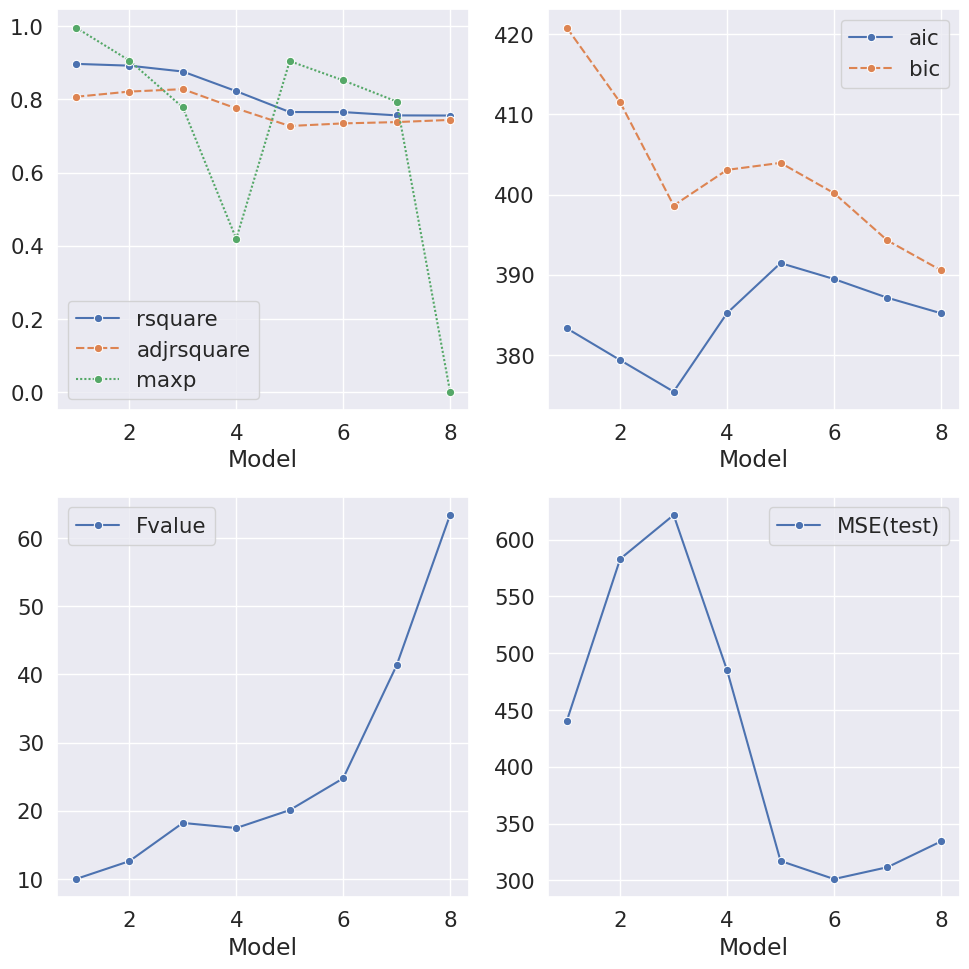

In [282]:
metrics = [['rsquare', 'adjrsquare', 'maxp'], ['aic', 'bic'], ['Fvalue'], ['MSE(test)']]

fig= plt.figure(figsize=(10,10))
for i, var in enumerate(metrics):
  ax=fig.add_subplot(2,2,i+1)
  sns.lineplot(data=model_metrics[var], ax=ax, marker='o')
  ax.set_xlabel('Model')

fig.tight_layout()
plt.show()

*Insights:*
1.   **Regression Model Analysis:**
*   Model 3: Highest adjusted R-squared, lowest AIC, and BIC. Balances predictive accuracy and simplicity.
*   Model 8: Simplest with lowest F value, indicating statistical significance and strong predictor-target relationship.
*   Model 6: Lowest MSE on the test set, excelling in prediction accuracy on unseen data.
2.   **Model Selection:**
*   Given the project's focus on simplicity, Model 8 is adopted as the preferred choice.

In [283]:
# Coefficients of the simplest model
models[-1].params

Intercept     26.872372
Item           1.690229
Display_km     1.567209
dtype: float64

# Conclusion

1.  Min. Active Time: 26.9 minutes
2.  Estimated Active Time:<br>
Total: 26.9 + Display_km * 1.6 + Item * 1.7<br>
Simplified: 27 + (Display_km + Item) * 1.5
3.  Order Acceptance Criteria:<br>
Accept order if:<br>
Pay - Display KM * 0.1 * 2 (round trip) - Desire Pay Rate * Estimated Active Time <br>is positive.

# Reference

Reference the analytic method of<br>https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide